# VS associations with cognitive performance (P) with an interaction with DRD2 polymorphism

***

In [37]:
import matplotlib.pyplot as plt
import ptitprince as pt
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.compat import unicode
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from IPython.core.display import HTML


### Loading Datasets

In [38]:
# Loading data
data = pd.read_csv('DRD2_subset_data.csv', delimiter=',')
data = data.dropna(subset=['P','Q','VS','DRD2', 'AGE', 'female_1'])

# Loading second IGT only data (Reformatted)
IGT_data = pd.read_csv('DRD2_IGT_subset_data.csv', delimiter=',')
IGT_data = IGT_data.dropna(subset=['IGT_scores', 'DRD2'])

### Reformatting Data

In [39]:
# Changing Categorical data to integers
data['DRD2'] = data['DRD2'].astype(int)
data['female_1'] = data['female_1'].astype(int)
IGT_data['DRD2'] = IGT_data['DRD2'].astype(int)

# Changing DRD2 data to category type
data['DRD2_cat'] = pd.cut(data['DRD2'], range(-1,2,1), labels=['Ins/Ins Carrier', 'Non-Carrier'])
data['DRD2_cat'] = data['DRD2_cat'].astype('object')
IGT_data['DRD2_cat'] = pd.cut(IGT_data['DRD2'], range(-1,2,1), labels=['Ins/Ins Carrier', 'Non-Carrier'])
IGT_data['DRD2_cat'] = IGT_data['DRD2_cat'].astype('object')

# Splitting data based on DRD2 polymorphism
low = data[data['DRD2'] == 1] # Low D2 Receptors
normal = data[data['DRD2'] == 0] # Normal D2 Receptors

## Distribution Plots

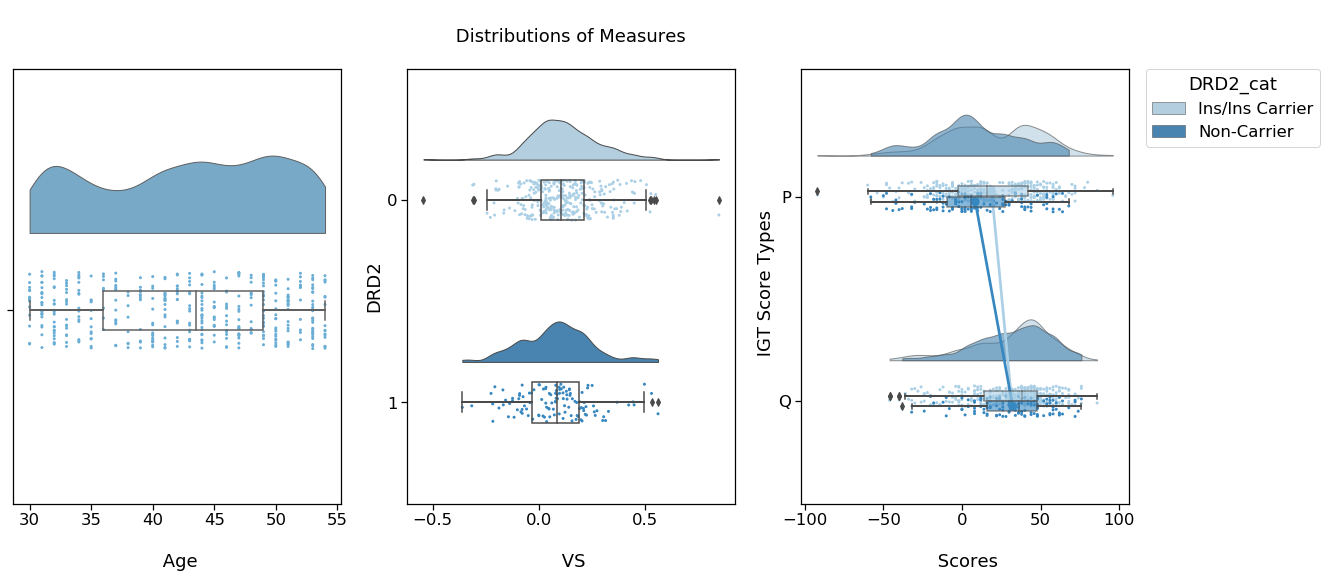

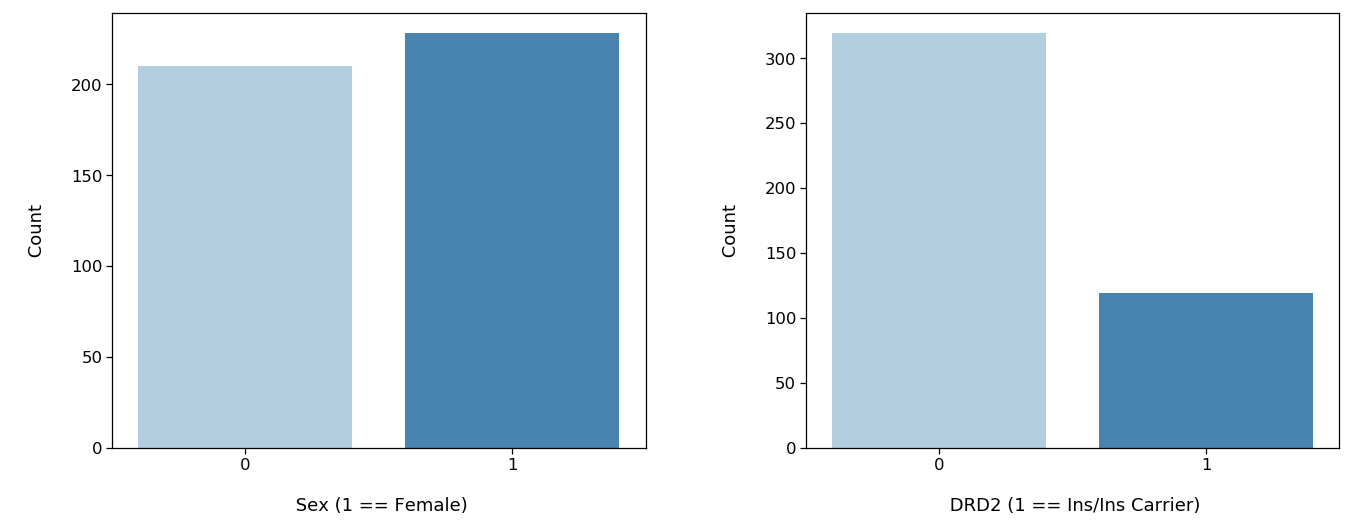

In [40]:
# Setting style of figures
sns.set_context("notebook", font_scale=1.5)

# Configuring 1st row of grid of plots
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.2)
fig.set_figheight(8)
fig.set_figwidth(20)

# Age Rain Cloud Plot
ax = fig.add_subplot(1, 3, 1)
age = pt.RainCloud(y='AGE', orient='h',data=data, width_viol=.4, width_box=.1, figsize=(7,5), 
                   palette="Blues",ax=ax)
age.set(xlabel='\n Age')

# VS Rain Cloud Plot
ax = fig.add_subplot(1, 3, 2)
VS = pt.RainCloud(y='VS', x='DRD2', data=data, orient='h', width_viol=.4, width_box=.2, figsize=(7,5), 
                  palette="Blues", ax=ax)
VS.set(xlabel='\n VS', title='\n Distributions of Measures \n')

# IGT Scores Rain Cloud Plots
ax = fig.add_subplot(1, 3, 3)
IGT = pt.RainCloud(y='IGT_scores', x='IGT_score_type', hue='DRD2_cat', data=IGT_data, orient='h', 
                         width_viol=.4, width_box=.1, figsize=(7,5), palette='Blues', alpha=.6, ax=ax,
                          dodge=True, pointplot=True) #Can comment out if lines aren't helpful
IGT.set(xlabel='\n Scores', ylabel='\n IGT Score Types')

# Configuring 2nd row of grid of plots
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=.3)
fig.set_figheight(8)
fig.set_figwidth(22)

# Sex Bar Plot
ax = fig.add_subplot(1, 2, 1)
sex = sns.catplot(x="female_1", kind="count", data=data, palette="Blues", ax=ax)
ax.set(xlabel='\n Sex (1 == Female)', ylabel='\n Count \n')

# DRD2 Bar Plot
ax = fig.add_subplot(1, 2, 2)
DRD2 = sns.catplot(x="DRD2", kind="count", data=data, palette="Blues", ax=ax)
ax.set(xlabel='\n DRD2 (1 == Ins/Ins Carrier)', ylabel='\n Count \n')
plt.close(3)
plt.close(4)
plt.show()

***


# T-Tests

### T-Test between DRD2 vs P and Q

In [41]:
t_test_results = stats.ttest_ind(low.iloc[:,2:5], normal.iloc[:,2:5], equal_var=True)
cols = ['P', 'Q', 'VS']
pd.DataFrame({'Statistics':t_test_results.statistic[0:], 'P-values':t_test_results.pvalue}, cols)

,Statistics,P-values
P,-3.230837,0.001328
Q,0.539049,0.590128
VS,-1.771730,0.077138


### Linear Regression Plots

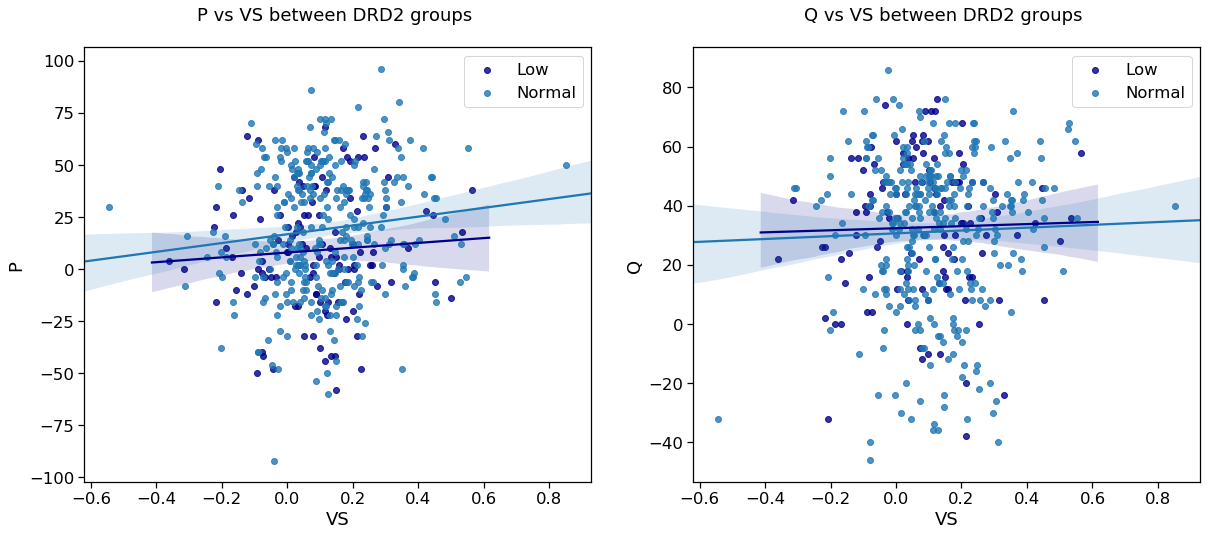

In [42]:
# Configuring grid of plots
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.2)
fig.set_figheight(8)
fig.set_figwidth(20)

# P vs VS between DRD2 groups Scatter Plot
ax = fig.add_subplot(1, 2, 1)
scatter_P_low = sns.regplot(x='VS', y='P', data=low, label='Low', color="darkblue", ax=ax).legend()
scatter_P_normal = sns.regplot(x='VS', y='P', data=normal, label='Normal').legend()
ax.set(title='P vs VS between DRD2 groups \n')

# Q vs VS between DRD2 groups Scatter Plot
ax = fig.add_subplot(1, 2, 2)
scatter_Q_low = sns.regplot(x='VS', y='Q', data=low, label='Low', color="darkblue", ax=ax).legend()
scatter_Q_normal = sns.regplot(x='VS', y='Q', data=normal, label='Normal').legend()
ax.set(title='Q vs VS between DRD2 groups \n')
plt.show()

*****


# Linear Regression

## P ~ DRD2 + VS + DRD2 * VS

In [105]:
target = pd.DataFrame(data.P, columns=['P'])
x = pd.DataFrame(data, columns=['DRD2','VS'])
y = target['P']
results_P = smf.ols(formula='P ~ DRD2 + VS + DRD2 * VS',data=data).fit()
HTML(results_P.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,16.7039,2.020,8.269,0.000,12.733,20.674
DRD2,-8.7905,3.634,-2.419,0.016,-15.932,-1.649
VS,21.1400,10.020,2.110,0.035,1.447,40.833
DRD2:VS,-9.5730,18.830,-0.508,0.611,-46.582,27.436


## Q ~ DRD2 + VS + DRD2 * VS

In [106]:
target = pd.DataFrame(data.P, columns=['Q'])
x = pd.DataFrame(data, columns=['DRD2','VS'])
y = target['Q']
results_Q = smf.ols(formula='Q ~ DRD2 + VS + DRD2 * VS',data=data).fit()
HTML(results_Q.summary().tables[1].as_html())

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,30.6606,1.746,17.563,0.000,27.230,34.092
DRD2,1.7348,3.140,0.553,0.581,-4.437,7.906
VS,4.7830,8.658,0.552,0.581,-12.234,21.801
DRD2:VS,-1.3082,16.272,-0.080,0.936,-33.289,30.673


### Bootstrap Permutation

In [138]:
np.random.seed(123)
coef_collection = []
def bootstrap(x):
    for i in range(0,1500):
        x_rand = np.random.choice(data[x],438, replace=False)
        DRD2_rand = np.random.choice(data['DRD2'],438)
        VS_rand = np.random.choice(data['VS'],438)
        rand_data = pd.DataFrame(data={'DRD2':DRD2_rand, 'VS':VS_rand, x:x_rand})
        results_rand = smf.ols(formula= x + ' ~ DRD2 + VS + DRD2 * VS', data=rand_data).fit()
        coef_collection.append(results_rand.params[2])
    return coef_collection

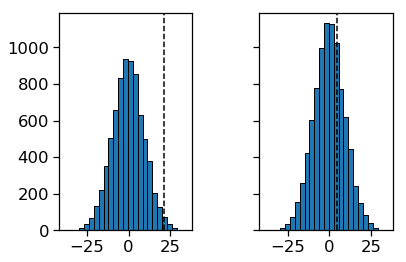

In [141]:
# Configuring grid of plots
fig, axs = plt.subplots(1, 2, sharey = True, gridspec_kw={'wspace': .5})

# Bootstrap Permutation Histogram Plot for P
axs[0].hist(bootstrap('P'), bins=25, edgecolor='k')
axs[0].axvline(x=results_P.params[2], color='black', linestyle='dashed')
#plt.title(text='P Bootstrap')

# Bootstrap Permutation Histogram Plot for Q
axs[1].hist(bootstrap('Q'), bins=25, edgecolor='k')
axs[1].axvline(x=results_Q.params[2], color='black', linestyle='dashed')
#plt.title(text='Q Bootstrap')

plt.show()